In [1]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
import importlib.util
import glob
from PIL import Image
from sklearn.manifold import TSNE

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


# Oil Palm

In [3]:
## User Param
# # Amazon
# args = {'dataset':'amazon',
#         'folder_name':'/home/yoyo/Desktop/SimCLR/runs/amazon_Jul05_23-00-54_iter200_yoyo',
#         }
# Oil Palm
args = {'dataset':'oilpalm',
        'folder_name':'/home/yoyo/Desktop/SimCLR/runs_oilpalm/Jul05_21-43-21_iter200_lr1e-4_yoyo',
        }


In [4]:
checkpoints_folder = os.path.join(args['folder_name'], 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 128,
 'epochs': 200,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(128,128,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [5]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs_oilpalm/Jul05_21-43-21_iter200_lr1e-4_yoyo/checkpoints'

In [6]:
def _load_data(prefix="train", img_size=128):
    img_list = glob.glob('../data/satellite/' + args['dataset'] + '/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).convert('RGB').resize((img_size, img_size))
        X_train.append(img)
        img.load()
    X_train = np.stack(X_train).transpose(0,3,1,2)
    
    if args['dataset'] == 'amazon':
        tag = 'agri'
    else:
        tag = 'palm'
    y_train = np.array([f.split('/')[-2] == tag for f in img_list])
    
    print("===  {} dataset ===".format(args['dataset']))
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train

In [7]:
# load facemask train data
X_train, y_train = _load_data("train")

===  oilpalm dataset ===
train images
(187, 3, 128, 128)
(187,)


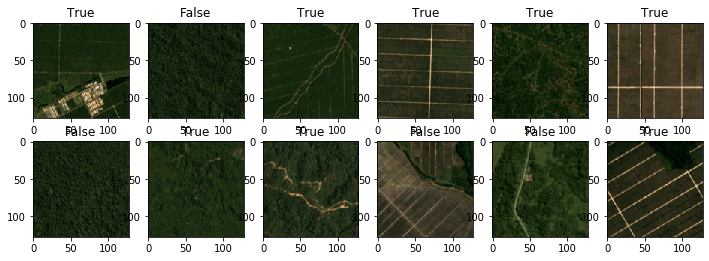

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [9]:
# load facemask test data
X_test, y_test = _load_data("test")

===  oilpalm dataset ===
test images
(193, 3, 128, 128)
(193,)


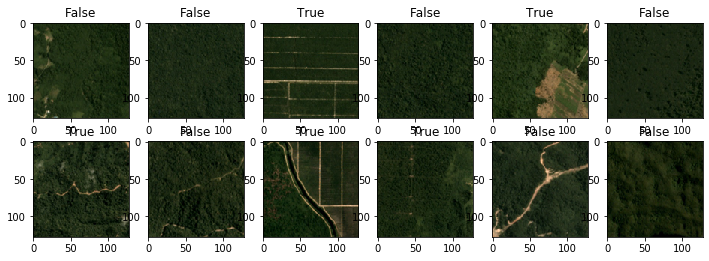

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[i].transpose(1,2,0))
    ax.title.set_text(y_test[i])
plt.show()

## Protocol #2 Logisitc Regression

In [11]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [12]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [13]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [14]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(187, 512)


In [15]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(193, 512)


In [23]:
X_embedded = TSNE(n_components=2).fit_transform(X_train_feature)
X_embedded.shape

(187, 2)

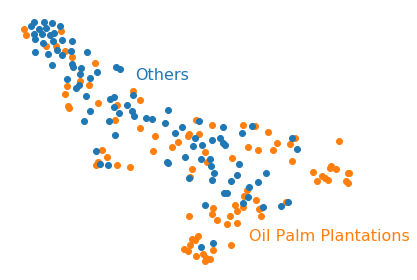

In [28]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


agri = y_train
scatter = plt.scatter(X_embedded[agri,0], X_embedded[agri,1], color='#ff7f0e', label='Oil Palm Plantations')
plt.text(X_embedded[agri,0].mean()+3, X_embedded[agri,1].mean()-10, 'Oil Palm Plantations', fontsize=16, color='#ff7f0e')

noagri = ~y_train
scatter = plt.scatter(X_embedded[noagri,0], X_embedded[noagri,1], color='#1f77b4', label='Others')
plt.text(X_embedded[noagri,0].mean()-.5, X_embedded[noagri,1].mean()+4.5, 'Others', fontsize=16, color='#1f77b4')

plt.xlabel('')
plt.xticks([])
plt.ylabel('')
plt.yticks([])

plt.tight_layout()
plt.savefig('p3.png', dpi=300)

# Amazon

In [63]:
## User Param
# Amazon
args = {'dataset':'amazon',
        'folder_name':'/home/yoyo/Desktop/SimCLR/runs/amazon_Jul05_23-00-54_iter200_yoyo',
        }

In [64]:
checkpoints_folder = os.path.join(args['folder_name'], 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 256,
 'epochs': 200,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(128,128,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [65]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/amazon_Jul05_23-00-54_iter200_yoyo/checkpoints'

In [66]:
def _load_data(prefix="train", img_size=128):
    img_list = glob.glob('../data/satellite/' + args['dataset'] + '/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).convert('RGB').resize((img_size, img_size))
        X_train.append(img)
        img.load()
    X_train = np.stack(X_train).transpose(0,3,1,2)
    
    if args['dataset'] == 'amazon':
        tag = 'agri'
    else:
        tag = 'palm'
    y_train = np.array([f.split('/')[-2] == tag for f in img_list])
    
    print("===  {} dataset ===".format(args['dataset']))
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train

In [67]:
# load facemask train data
X_train, y_train = _load_data("train")

===  amazon dataset ===
train images
(1055, 3, 128, 128)
(1055,)


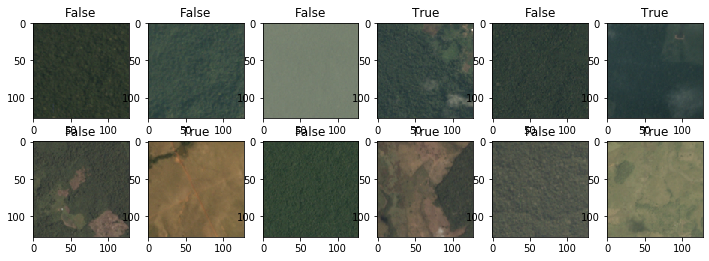

In [68]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [69]:
# load facemask test data
X_test, y_test = _load_data("test")

===  amazon dataset ===
test images
(1056, 3, 128, 128)
(1056,)


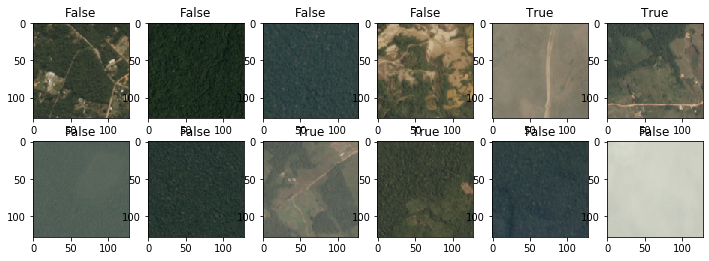

In [70]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[i].transpose(1,2,0))
    ax.title.set_text(y_test[i])
plt.show()

## Protocol #2 Logisitc Regression

In [71]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [72]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [73]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [124]:
i = 9

In [125]:
from scipy import ndimage, misc

In [126]:
img = X_train[i].transpose(1,2,0)
img_rot = ndimage.rotate(img,90)
img_flip = np.fliplr(img)
img_zoom = ndimage.zoom(img,1.1)[6:6+128,6:6+128,:]

In [214]:
from PIL import Image
Image.fromarray(img).save('original.png', "PNG")

In [192]:
j = 20
img_j = X_train[j].transpose(1,2,0)

In [215]:
Image.fromarray(img_j).save('original_2.png', "PNG")

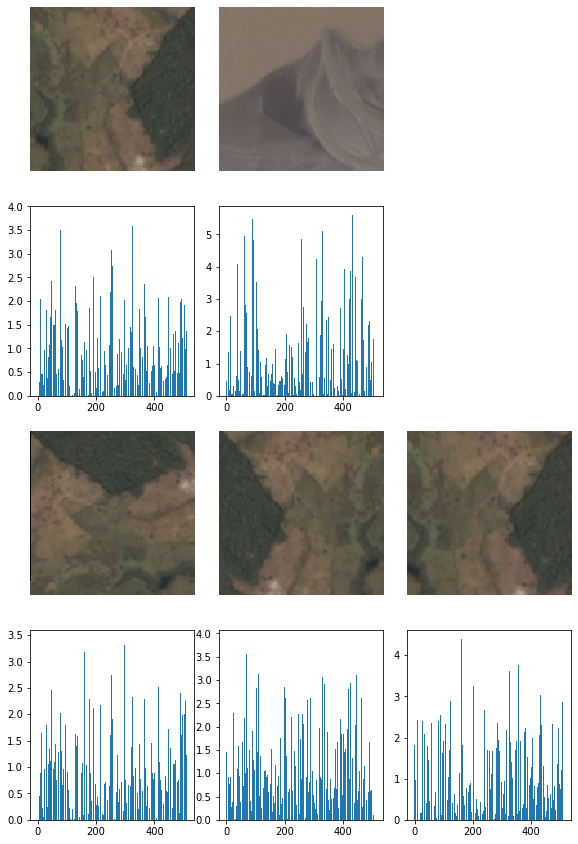

In [210]:
fig = plt.figure(figsize=(8,12))
plt.subplot(431)
plt.imshow(img)
plt.axis('off')

plt.subplot(434)
plt.bar(range(512),X_train_feature[i])

plt.subplot(432)
plt.imshow(img_j)
plt.axis('off')

plt.subplot(435)
plt.bar(range(512),X_train_feature[j])

plt.subplot(437)
plt.imshow(img_rot)
plt.axis('off')

plt.subplot(4,3,10)
plt.bar(range(512),X_train_feature[-3])

plt.subplot(438)
plt.imshow(img_flip)
plt.axis('off')

plt.subplot(4,3,11)
plt.bar(range(512),X_train_feature[-2])

plt.subplot(439)
plt.imshow(img_zoom)
plt.axis('off')

plt.subplot(4,3,12)
plt.bar(range(512),X_train_feature[-1])

plt.tight_layout()
plt.savefig('p7.png', dpi=300)

In [207]:
X_train_feature.shape

(1058, 512)

In [202]:
X_train_feature[i].min()

0.0

In [128]:
X_add = np.stack((img_rot.transpose(2,0,1), img_flip.transpose(2,0,1), img_zoom.transpose(2,0,1)))

In [216]:
Image.fromarray(img_rot).save('rotate90.png', "PNG")
Image.fromarray(img_flip).save('flip.png', "PNG")
Image.fromarray(img_zoom).save('zoom.png', "PNG")

In [129]:
X_add.shape

(3, 3, 128, 128)

In [130]:
y_add = np.array([y_train[i]]*3)

In [131]:
X_train.shape

(1055, 3, 128, 128)

In [132]:
y_add.shape

(3,)

In [133]:
X_train_add = np.concatenate((X_train, X_add))
y_train_add = np.concatenate((y_train, y_add))

In [134]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train_add, y_train_add, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(1058, 512)


In [135]:
X_embedded = TSNE(n_components=2).fit_transform(X_train_feature)
X_embedded.shape

(1058, 2)

In [154]:
xx = [-32, -32, -22, -22, -32]
yy = [0, 10, 10, 0, 0]

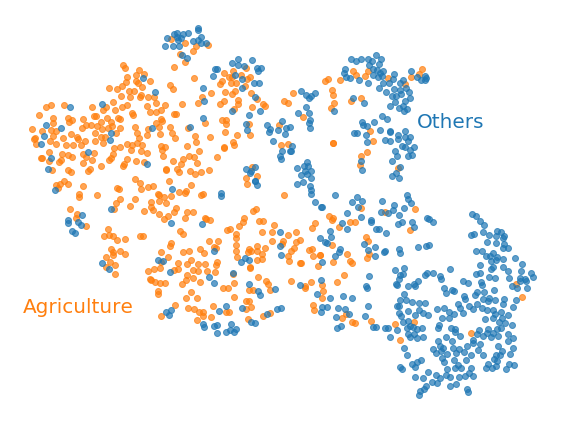

In [164]:
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

agri = y_train_add
agri[i] = False
agri[-3:] = False
scatter = plt.scatter(X_embedded[agri,0], X_embedded[agri,1], color='#ff7f0e', alpha=0.7)
plt.text(X_embedded[agri,0].mean()-35, X_embedded[agri,1].mean()-25, 'Agriculture', fontsize=20, color='#ff7f0e')

noagri = ~y_train_add
noagri[i] = False
noagri[-3:] = False
scatter = plt.scatter(X_embedded[noagri,0], X_embedded[noagri,1], color='#1f77b4', alpha=0.7)
plt.text(X_embedded[noagri,0].mean()+10, X_embedded[noagri,1].mean()+20, 'Others', fontsize=20, color='#1f77b4')

# scatter = plt.scatter(X_embedded[-1,0], X_embedded[-1,1], marker='s', color='#2ca02c')
# scatter = plt.scatter(X_embedded[-2,0], X_embedded[-2,1], marker='^', color='#9467bd')
# scatter = plt.scatter(X_embedded[-3,0], X_embedded[-3,1], marker='D', color='#17becf')
# scatter = plt.scatter(X_embedded[i,0], X_embedded[i,1], marker='*', color='#d62728')

# plt.plot(xx, yy, '--', color='#7f7f7f')

plt.xlabel('')
plt.xticks([])
plt.ylabel('')
plt.yticks([])

plt.tight_layout()
plt.savefig('p4.png', dpi=300)

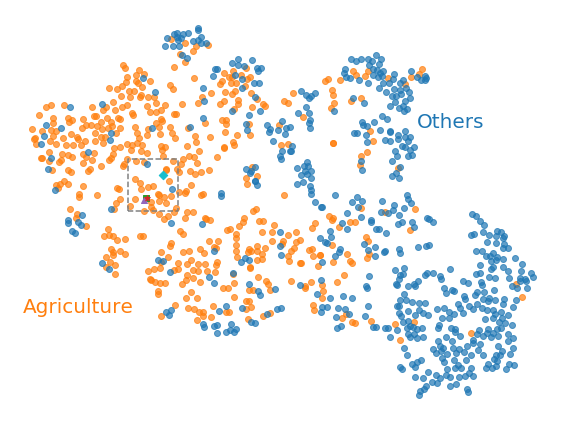

In [217]:
fig, ax = plt.subplots(figsize=(8,6))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

agri = y_train_add
agri[i] = False
agri[-3:] = False
scatter = plt.scatter(X_embedded[agri,0], X_embedded[agri,1], color='#ff7f0e', alpha=0.7)
plt.text(X_embedded[agri,0].mean()-35, X_embedded[agri,1].mean()-25, 'Agriculture', fontsize=20, color='#ff7f0e')

noagri = ~y_train_add
noagri[i] = False
noagri[-3:] = False
scatter = plt.scatter(X_embedded[noagri,0], X_embedded[noagri,1], color='#1f77b4', alpha=0.7)
plt.text(X_embedded[noagri,0].mean()+10, X_embedded[noagri,1].mean()+20, 'Others', fontsize=20, color='#1f77b4')

scatter = plt.scatter(X_embedded[-1,0], X_embedded[-1,1], marker='s', color='#2ca02c')
scatter = plt.scatter(X_embedded[-2,0], X_embedded[-2,1], marker='^', color='#9467bd')
scatter = plt.scatter(X_embedded[-3,0], X_embedded[-3,1], marker='D', color='#17becf')
scatter = plt.scatter(X_embedded[i,0], X_embedded[i,1], marker='*', color='#d62728')

plt.plot(xx, yy, '--', color='#7f7f7f')

plt.xlabel('')
plt.xticks([])
plt.ylabel('')
plt.yticks([])

plt.tight_layout()
plt.savefig('p8.png', dpi=300)

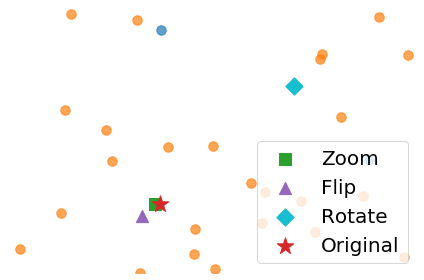

In [163]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

agri = y_train_add
agri[i] = False
agri[-3:] = False
scatter = plt.scatter(X_embedded[agri,0], X_embedded[agri,1], 90, color='#ff7f0e', alpha=0.7)
# plt.text(X_embedded[agri,0].mean()-30, X_embedded[agri,1].mean()+20, 'Agriculture', fontsize=20, color='#ff7f0e')

noagri = ~y_train_add
noagri[i] = False
noagri[-3:] = False
scatter = plt.scatter(X_embedded[noagri,0], X_embedded[noagri,1], 90, color='#1f77b4', alpha=0.7)
# plt.text(X_embedded[noagri,0].mean()+14, X_embedded[noagri,1].mean()-9, 'Others', fontsize=20, color='#1f77b4')

scatter = plt.scatter(X_embedded[-1,0], X_embedded[-1,1], 150, marker='s', color='#2ca02c', label='Zoom')
scatter = plt.scatter(X_embedded[-2,0], X_embedded[-2,1], 150, marker='^', color='#9467bd', label='Flip')
scatter = plt.scatter(X_embedded[-3,0], X_embedded[-3,1], 150, marker='D', color='#17becf', label='Rotate')
scatter = plt.scatter(X_embedded[i,0], X_embedded[i,1], 300, marker='*', color='#d62728', label='Original')
plt.xlabel('')
plt.xticks([])
plt.ylabel('')
plt.yticks([])
plt.ylim([0,10])
plt.xlim([-32,-22])

plt.rc('legend',fontsize=20)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('p6.png', dpi=300)